In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from notifiers import get_notifier

In [2]:
def new_time_features(df, max_temp_col, min_temp_col, press_col, hum_col):
    all_columns = [max_temp_col, min_temp_col, press_col, hum_col]
    temp_columns = [max_temp_col, min_temp_col]
    
    df['month'] = df.index.month
    df['day'] = df.index.day
    
    for col in all_columns:
        df['rolling_mean_'+col] = df[col].shift(7).rolling(10).mean()
        
    df['lag_7_max_temp'] = df[max_temp_col].shift(7)
    df['lag_20_max_temp'] = df[max_temp_col].shift(20)
    
    for col in temp_columns:
        df['lag_15_'+col] = df[col].shift(15)
        df['lag_180_'+col] = df[col].shift(180)
    
    return df

In [3]:
def search_best_model(model, model_name, params, X, y):
    print('<<<-------------------...Searching for best model...------------------->>>')
    clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    score = -1 * clf.best_score_
    print('------------------->>>Best model found successfully!<<<-------------------')
    print('\nBest {} MAE:'.format(model_name), score, '\nBest {} model:'.format(model_name), clf.best_estimator_)
    return score, clf.best_estimator_

In [4]:
def test_and_score(model):
    model.fit(X, y)
    return mean_absolute_error(y_test, model.predict(X_test))

In [5]:
def make_predictions(df, model):
    df_pred = df.iloc[-7:]
    X_pred = df_pred.drop('max_temp', axis=1)
    preds = best_cb_model.predict(X_pred)
    
    X_pred = X_pred.copy()
    X_pred['День недели'] = X_pred.index.day_name()
    X_pred['Температура'] = preds
    X_pred['Температура'] = X_pred['Температура'].round(1)
    X_pred = X_pred[['День недели', 'Температура']]
    
    days_week_rus = {
        'Monday':'Понедельник', 'Tuesday':'Вторник', 'Wednesday':'Среда',
        'Thursday':'Четверг', 'Friday':'Пятница',
        'Saturday':'Суббота', 'Sunday':'Воскресенье'
    }
    X_pred['День недели'] = X_pred['День недели'].replace(days_week_rus)
    return X_pred

In [6]:
def telegram_notifier_to_channel(
    token='<telegram-bot token>',
    chat_id='@<channel name>'
):
    def f(text):
        telegram = get_notifier('telegram')
        telegram.notify(
            message=text,
            token=token,
            chat_id=chat_id
        )
    return f

In [7]:
def telegram_notifier_to_bot(
    token='<telegram-bot token>',
    chat_id='<chat_with_bot_number>'
):
    def f(text):
        telegram = get_notifier('telegram')
        telegram.notify(
            message=text,
            token=token,
            chat_id=chat_id
        )
    return f

In [8]:
def show_correlogram(df):
    plt.figure(figsize=(10,10), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [9]:
def importances(model, model_name):
    model.fit(X, y)
    result = permutation_importance(model, X, y, scoring='neg_mean_absolute_error', n_jobs=4, random_state=555)
    per_imp = pd.DataFrame(
        result.importances_mean, index=X.columns, columns=['permutation_importances']
    ).sort_values(by=['permutation_importances'])
    
    per_imp.plot(
        kind='barh', title='Permutation importances {}'.format(model_name), figsize=(10, 8)
    )
    plt.show()
    return per_imp.sort_values(by=['permutation_importances'], ascending=False)

In [10]:
df_all_final = pd.read_csv('Datasets/weather/weather.csv', index_col=[0], parse_dates=[0], dayfirst=True)
df_all = df_all_final.drop(['min_temp', 'pressure', 'humidity'], axis=1)

In [11]:
df_all.head()

,max_temp,month,day,rolling_mean_max_temp,rolling_mean_min_temp,rolling_mean_pressure,rolling_mean_humidity,lag_7_max_temp,lag_20_max_temp,lag_15_max_temp,lag_180_max_temp,lag_15_min_temp,lag_180_min_temp
2005-07-31,27.6,7,31,25.78,17.15,744.11,79.35,26.2,19.5,28.2,-6.6,17.7,-8.9
2005-08-01,26.1,8,1,25.69,17.36,743.74,78.32,27.2,25.3,27.2,-8.0,16.4,-11.0
2005-08-02,25.7,8,2,25.19,17.33,743.51,79.03,23.2,25.4,23.6,-10.6,18.1,-15.2
2005-08-03,23.8,8,3,24.88,17.47,743.40,80.82,24.1,27.0,23.8,-8.6,19.1,-19.9
2005-08-04,22.7,8,4,24.85,17.29,743.67,79.88,23.3,28.1,25.5,-8.1,16.0,-21.3


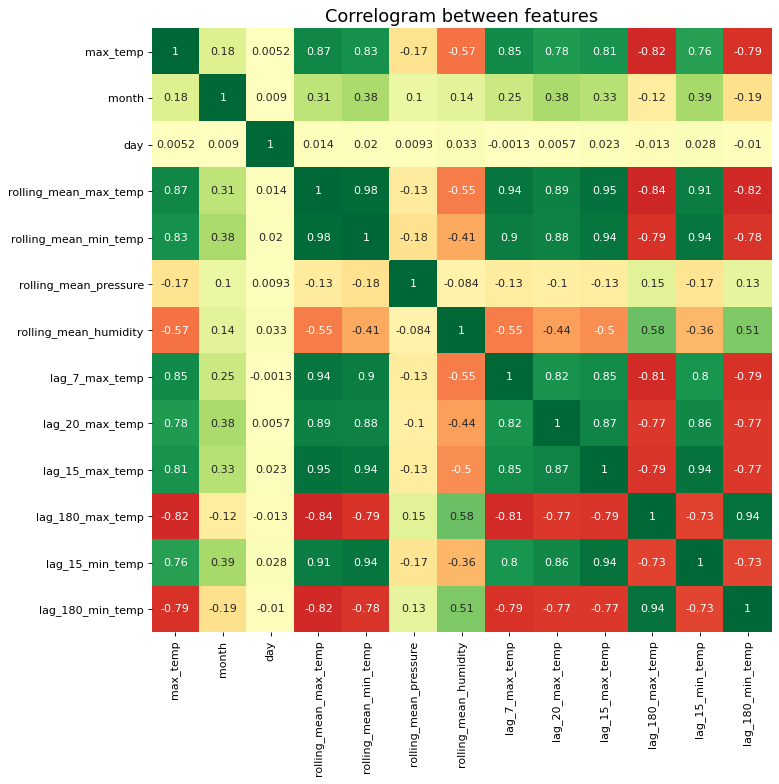

In [12]:
show_correlogram(df_all)

In [13]:
X = df_all.drop('max_temp', axis=1)
y = df_all['max_temp']
print('Features: {}\nTarget: {}'.format(X.shape, y.shape))

Features: (5888, 12)
Target: (5888,)


In [14]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.055, shuffle=False)
print('Features', X_train.shape, X_valid.shape, X_test.shape, sep='  |  ')
print('Target ', y_train.shape, y_valid.shape, y_test.shape, sep='   |   ')
print('Ratio',
      round(len(X_train) / len(df_all) * 100),
      round(len(X_valid) / len(df_all) * 100),
      round(len(X_test) / len(df_all) * 100), sep='     |     ')

Features  |  (5285, 12)  |  (308, 12)  |  (295, 12)
Target    |   (5285,)   |   (308,)   |   (295,)
Ratio     |     90     |     5     |     5


In [15]:
best_cb_score, best_cb_model = search_best_model(
    model=CatBoostRegressor(),
    model_name='CatBoost',
    params={'iterations': range(1000, 3100, 100), 'verbose': [0],
            'random_state': [555], 'loss_function': ['MAE']},
    X=X, y=y
)

<<<-------------------...Searching for best model...------------------->>>
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  6.9min finished


------------------->>>Best model found successfully!<<<-------------------

Best CatBoost MAE: 4.081077902165707 
Best CatBoost model: <catboost.core.CatBoostRegressor object at 0x7fba20ed7ee0>


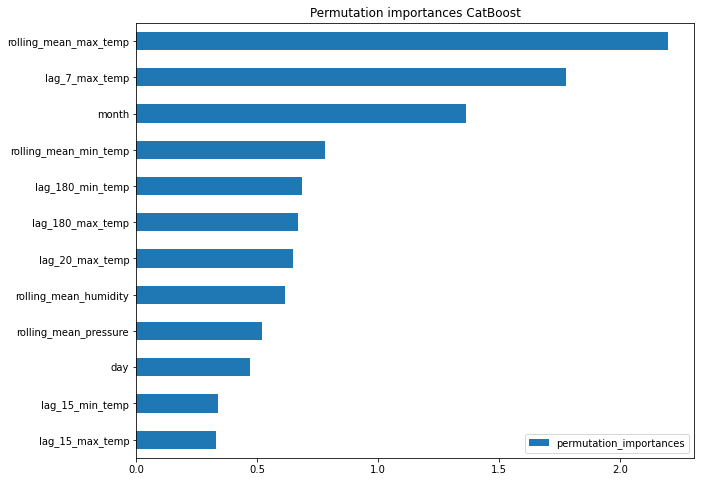

,permutation_importances
rolling_mean_max_temp,2.195531
lag_7_max_temp,1.774392
month,1.364055
rolling_mean_min_temp,0.778662
lag_180_min_temp,0.686012
lag_180_max_temp,0.669952
lag_20_max_temp,0.649668
rolling_mean_humidity,0.613960
rolling_mean_pressure,0.520765
day,0.470804


In [16]:
importances(best_cb_model, 'CatBoost')

In [17]:
send_bot = telegram_notifier_to_bot()
send_bot('Я обучился! Муррр!')

In [18]:
display(
    pd.DataFrame(data=([best_cb_score, test_and_score(best_cb_model)],
                       ['--------', test_and_score(DummyRegressor())]),
                 columns=['Valid MAE', 'Test MAE'],
                 index=['CatBoost', 'Dummy'])
)

,Valid MAE,Test MAE
CatBoost,4.08108,4.330296
Dummy,--------,12.064070


In [19]:
send_bot(
    'Мои успехи:\nValid MAE: {:.2f}\nTest MAE: {:.2f}'
    .format(best_cb_score, test_and_score(best_cb_model))
)

In [20]:
X = df_all.drop('max_temp', axis=1)
y = df_all['max_temp']
print('Features: {}\nTarget: {}'.format(X.shape, y.shape))

Features: (5888, 12)
Target: (5888,)


In [21]:
best_cb_model.fit(X, y)

In [22]:
next_7_dates = pd.Series(pd.date_range(df_all_final.index[-1], periods=7, freq='D').shift().normalize())
next_7_dates

0   2021-09-13
1   2021-09-14
2   2021-09-15
3   2021-09-16
4   2021-09-17
5   2021-09-18
6   2021-09-19
dtype: datetime64[ns]

In [23]:
df_all_next = pd.DataFrame(index=next_7_dates, columns=df_all_final.columns)
df_all = pd.concat([df_all_final, df_all_next])
df_all.tail(10)

,max_temp,min_temp,pressure,humidity,month,day,rolling_mean_max_temp,rolling_mean_min_temp,rolling_mean_pressure,rolling_mean_humidity,lag_7_max_temp,lag_20_max_temp,lag_15_max_temp,lag_180_max_temp,lag_15_min_temp,lag_180_min_temp
2021-09-10,19.6,13.6,748.2,87.1,9,10,19.71,12.64,745.95,77.86,11.6,20.9,19.3,2.7,13.2,-2.0
2021-09-11,17.0,10.0,750.8,85.4,9,11,18.85,12.48,745.02,79.06,10.6,19.6,22.0,3.0,15.4,1.8
2021-09-12,20.0,12.0,747.3,85.3,9,12,17.91,11.74,745.12,78.93,9.9,20.2,21.0,3.2,13.4,-0.3
2021-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
new_time_features(df_all, 'max_temp', 'min_temp', 'pressure', 'humidity')
df_all.tail(10)

,max_temp,min_temp,pressure,humidity,month,day,rolling_mean_max_temp,rolling_mean_min_temp,rolling_mean_pressure,rolling_mean_humidity,lag_7_max_temp,lag_20_max_temp,lag_15_max_temp,lag_180_max_temp,lag_15_min_temp,lag_180_min_temp
2021-09-10,19.6,13.6,748.2,87.1,9,10,19.71,12.64,745.95,77.86,11.6,20.9,19.3,2.7,13.2,-2.0
2021-09-11,17.0,10.0,750.8,85.4,9,11,18.85,12.48,745.02,79.06,10.6,19.6,22.0,3.0,15.4,1.8
2021-09-12,20.0,12.0,747.3,85.3,9,12,17.91,11.74,745.12,78.93,9.9,20.2,21.0,3.2,13.4,-0.3
2021-09-13,NaN,NaN,NaN,NaN,9,13,17.00,10.63,745.33,78.09,12.9,19.3,22.7,2.2,13.6,-0.8
2021-09-14,NaN,NaN,NaN,NaN,9,14,16.16,9.96,745.47,79.48,12.6,19.2,22.8,2.0,16.0,-1.2
2021-09-15,NaN,NaN,NaN,NaN,9,15,15.34,9.69,745.62,80.69,14.5,19.3,25.2,1.3,16.9,-1.6
2021-09-16,NaN,NaN,NaN,NaN,9,16,14.83,9.46,745.57,80.48,17.7,22.0,19.9,0.0,13.0,-5.4
2021-09-17,NaN,NaN,NaN,NaN,9,17,14.27,9.13,745.80,81.11,19.6,21.0,13.4,2.2,11.0,-4.5
2021-09-18,NaN,NaN,NaN,NaN,9,18,13.98,8.83,746.98,81.27,17.0,22.7,11.6,2.8,5.6,-0.7
2021-09-19,NaN,NaN,NaN,NaN,9,19,14.64,8.93,747.69,82.11,20.0,22.8,10.6,0.9,6.7,-3.3


In [25]:
df_all = df_all.drop(['min_temp', 'pressure', 'humidity'], axis=1)
df_all.tail(10)

,max_temp,month,day,rolling_mean_max_temp,rolling_mean_min_temp,rolling_mean_pressure,rolling_mean_humidity,lag_7_max_temp,lag_20_max_temp,lag_15_max_temp,lag_180_max_temp,lag_15_min_temp,lag_180_min_temp
2021-09-10,19.6,9,10,19.71,12.64,745.95,77.86,11.6,20.9,19.3,2.7,13.2,-2.0
2021-09-11,17.0,9,11,18.85,12.48,745.02,79.06,10.6,19.6,22.0,3.0,15.4,1.8
2021-09-12,20.0,9,12,17.91,11.74,745.12,78.93,9.9,20.2,21.0,3.2,13.4,-0.3
2021-09-13,NaN,9,13,17.00,10.63,745.33,78.09,12.9,19.3,22.7,2.2,13.6,-0.8
2021-09-14,NaN,9,14,16.16,9.96,745.47,79.48,12.6,19.2,22.8,2.0,16.0,-1.2
2021-09-15,NaN,9,15,15.34,9.69,745.62,80.69,14.5,19.3,25.2,1.3,16.9,-1.6
2021-09-16,NaN,9,16,14.83,9.46,745.57,80.48,17.7,22.0,19.9,0.0,13.0,-5.4
2021-09-17,NaN,9,17,14.27,9.13,745.80,81.11,19.6,21.0,13.4,2.2,11.0,-4.5
2021-09-18,NaN,9,18,13.98,8.83,746.98,81.27,17.0,22.7,11.6,2.8,5.6,-0.7
2021-09-19,NaN,9,19,14.64,8.93,747.69,82.11,20.0,22.8,10.6,0.9,6.7,-3.3


In [26]:
predictions_temperature = make_predictions(df_all, best_cb_model)
predictions_temperature

,День недели,Температура
2021-09-13,Понедельник,16.3
2021-09-14,Вторник,16.1
2021-09-15,Среда,15.6
2021-09-16,Четверг,16.4
2021-09-17,Пятница,15.8
2021-09-18,Суббота,15.1
2021-09-19,Воскресенье,16.0


In [27]:
predictions_text = ('Предсказания на неделю:'
                    '\nc "{}" по "{}"\n'
                    '\nТемпература | День недели'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    .format(predictions_temperature.index[0].date(),
                            predictions_temperature.index[6].date(),
                            predictions_temperature.iloc[0][1],
                            predictions_temperature.iloc[0][0],
                            predictions_temperature.iloc[1][1],
                            predictions_temperature.iloc[1][0],
                            predictions_temperature.iloc[2][1],
                            predictions_temperature.iloc[2][0],
                            predictions_temperature.iloc[3][1],
                            predictions_temperature.iloc[3][0],
                            predictions_temperature.iloc[4][1],
                            predictions_temperature.iloc[4][0],
                            predictions_temperature.iloc[5][1],
                            predictions_temperature.iloc[5][0],
                            predictions_temperature.iloc[6][1],
                            predictions_temperature.iloc[6][0])
                   )

In [28]:
send_bot(predictions_text)

In [29]:
send_channel = telegram_notifier_to_channel()
send_channel(predictions_text)